# Resources
---
- Coherence: https://markroxor.github.io/gensim/static/notebooks/topic_coherence_tutorial.html
- Coherence Score guidelines: https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad
- Good way to Preprocess data: https://stackabuse.com/python-for-nlp-working-with-the-gensim-library-part-2/

In [489]:
import pandas as pd
import numpy as np
import string
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords

import gensim
from gensim import corpora, models


np.set_printoptions(precision=2)

In [474]:
count = CountVectorizer()
tfidf = TfidfTransformer(use_idf=True, norm = 'l2', smooth_idf=True)

In [443]:
data = pd.read_csv('content.txt', sep="/n", header=None, index_col=False)
documents = data[0]
documents.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


0    UK political system vulnerable to anti-democra...
1    Remain supporter Ángel Gurría says UK needs to...
2    Guardian/ICM survey finds rising interest in v...
3    Labour leader disappoints pro-EU MPs in addres...
4    Shahmir Sanni, a volunteer for Vote Leave, the...
Name: 0, dtype: object

In [497]:
def preprocessText(document):      
        document = re.sub(r'\W', ' ', str(document)) # Remove all the special characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document) # remove all single characters
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) # Remove single characters from the start
        document = re.sub(r'\s+', ' ', document, flags=re.I) # Substituting multiple spaces with single space
        document = document.lower() # Converting to Lowercase

        tokens = [word for word in document.split()]
        tokens = [word for word in words if word not in stop and word not in my_stopwords]

        return tokens

In [529]:
def tokenizer_basic(text):
    rem_punct = str.maketrans('', '', string.punctuation)
    words = [word.translate(rem_punct).lower() for word in text.split()]
    return [word for word in words if word not in stop and word not in my_stopwords]

def tokenizer_basic2(text):
    rem_punct = str.maketrans('', '', string.punctuation)
    words = [word.translate(rem_punct).lower() for word in text.split()]
    return [word for word in words if word not in stop]

In [530]:
# load our list of English stopwords
stop = stopwords.words('english')
my_stopwords = ['would', 'said', '-','–', 'the', 'could', 'brexit', 'uk', 'says', 'minister'
                , 'eu', 'goverment', 'parliament', 'mps', 'prime', 'one', 'government']

In [531]:
#texts = [preprocessText(doc) for doc in documents]
texts = [tokenizer_basic(doc) for doc in documents]
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(11964 unique tokens: ['150000', '19', '2016', '400', '4565000']...)


In [546]:
# Find most commonly occuring words
texts2 = [tokenizer_basic(doc) for doc in documents]
all_words = [word for sublist in texts2 for word in sublist ]
Counter(all_words).most_common(20)

[('deal', 633),
 ('may', 395),
 ('vote', 389),
 ('party', 338),
 ('johnson', 302),
 ('labour', 281),
 ('european', 260),
 ('leave', 247),
 ('nodeal', 239),
 ('agreement', 223),
 ('new', 218),
 ('also', 210),
 ('british', 209),
 ('referendum', 197),
 ('people', 197),
 ('campaign', 169),
 ('time', 166),
 ('support', 155),
 ('union', 154),
 ('tory', 152)]

In [532]:
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    #pprint(doc)
    break ## only print first iteration 

In [512]:
def computeCoherenceValues(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus, num_topics=9, id2word=dictionary, passes=10, workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

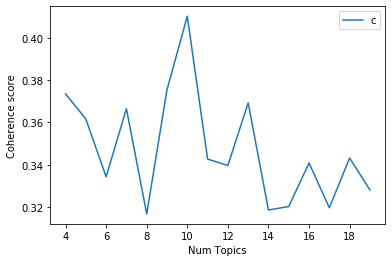

In [516]:
model_list, coherence_values = computeCoherenceValues(dictionary=dictionary, corpus=corpus, texts=texts, start=4, limit=20, step=1)

x = range(4, 20, 1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [533]:
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=50, workers=4)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"party" + 0.007*"labour" + 0.007*"support" + 0.006*"vote" + 0.006*"deal" + 0.005*"votes" + 0.005*"referendum" + 0.004*"voters" + 0.004*"leave" + 0.004*"may"
Topic: 1 
Words: 0.009*"backstop" + 0.008*"ireland" + 0.008*"agreement" + 0.007*"customs" + 0.007*"border" + 0.007*"deal" + 0.006*"union" + 0.006*"irish" + 0.005*"northern" + 0.005*"may"
Topic: 2 
Words: 0.010*"vote" + 0.009*"leave" + 0.008*"sanni" + 0.006*"campaign" + 0.004*"grimes" + 0.003*"russian" + 0.003*"cambridge" + 0.003*"political" + 0.003*"last" + 0.003*"it’s"
Topic: 3 
Words: 0.013*"deal" + 0.010*"johnson" + 0.006*"agreement" + 0.005*"tariffs" + 0.005*"nodeal" + 0.005*"trade" + 0.005*"october" + 0.005*"also" + 0.004*"place" + 0.004*"tory"
Topic: 4 
Words: 0.009*"campaign" + 0.004*"british" + 0.004*"bbc" + 0.004*"report" + 0.004*"russia" + 0.004*"scandal" + 0.004*"advertising" + 0.003*"public" + 0.003*"news" + 0.003*"belgian"
Topic: 5 
Words: 0.006*"british" + 0.004*"new" + 0.004*"deal" + 0.004*"peo

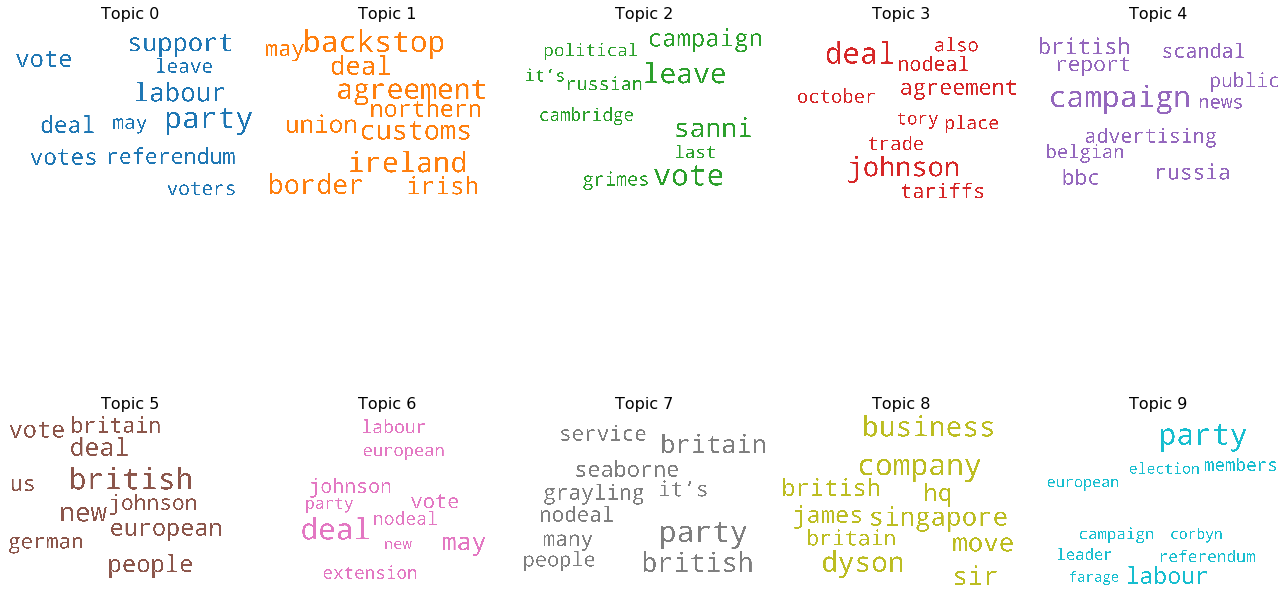

In [534]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(18,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()